In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Add, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def build_chexnet_fpn_classifier(input_shape=(224, 224, 3), num_classes=2):
    base_input = Input(shape=input_shape)

    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=base_input
    )
    base_model.trainable = False

    c1 = base_model.get_layer("conv1_relu").output
    c2 = base_model.get_layer("conv2_block6_concat").output
    c3 = base_model.get_layer("conv3_block12_concat").output
    c4 = base_model.get_layer("conv4_block24_concat").output

    # FPN layers
    p4 = Conv2D(256, kernel_size=1, padding="same")(c4)
    p3 = Add()([UpSampling2D()(p4), Conv2D(256, kernel_size=1, padding="same")(c3)])
    p2 = Add()([UpSampling2D()(p3), Conv2D(256, kernel_size=1, padding="same")(c2)])
    p1 = Add()([UpSampling2D()(p2), Conv2D(256, kernel_size=1, padding="same")(c1)])

    # Final convolutions for FPN outputs
    p1 = Conv2D(256, kernel_size=3, padding="same", activation="relu")(p1)

    # Classification head
    fpn_output = GlobalAveragePooling2D()(p1)
    fpn_output = Dense(256, activation='relu')(fpn_output)
    fpn_output = Dropout(0.5)(fpn_output)
    output = Dense(num_classes, activation='softmax')(fpn_output)  # Change to softmax for multi-class

    # Model definition
    model = Model(inputs=base_input, outputs=output)
    return model

model = build_chexnet_fpn_classifier(input_shape=(224, 224, 3), num_classes=2)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Dataset paths
train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

# Data generators for grayscale images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode='sparse'
)


Found 5224 images belonging to 2 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode='sparse'
)


Found 16 images belonging to 2 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
#convert grayscale images to RGB
def preprocess_images(generator):
    for x, y in generator:
        x_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))
        yield x_rgb, y

history = model.fit(
    preprocess_images(train_generator),
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=preprocess_images(val_generator),
    validation_steps=len(val_generator)
)

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 2989s 18s/step - accuracy: 0.7484 - loss: 0.5296 - val_accuracy: 0.6250 - val_loss: 0.7831
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 98s 596ms/step - accuracy: 0.9076 - loss: 0.2197 - val_accuracy: 0.6250 - val_loss: 0.9667
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 536ms/step - accuracy: 0.9277 - loss: 0.1739 - val_accuracy: 0.6250 - val_loss: 0.6832
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 543ms/step - accuracy: 0.9280 - loss: 0.1746 - val_accuracy: 0.8750 - val_loss: 0.3265
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 543ms/step - accuracy: 0.9373 - loss: 0.1517 - val_accuracy: 0.8125 - val_loss: 0.4425
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - accuracy: 0.9356 - loss: 0.1523 - val_accuracy: 0.8125 - val_loss: 0.3067
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.9514 - loss: 0.1348 - val_accuracy: 0.9375 - val_loss: 0.2622
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 535ms/step - accuracy: 0.9487 - loss: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(preprocess_images(test_generator), steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
y_pred = model.predict(preprocess_images(test_generator), steps=len(test_generator))
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def display_random_test_images(input_images, true_labels, pred_labels, class_names, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, idx in zip(axes.flatten(), range(num_images)):

        inp = input_images[idx].squeeze()

        true_label = true_labels[idx]
        pred_label = pred_labels[idx]


        ax.imshow(inp, cmap='gray')


        title = f"Predicted: {class_names[int(pred_label)]}\nActual: {class_names[int(true_label)]}"
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(title, color=color)


        ax.axis('off')

    plt.show()


test_images, true_labels, pred_labels = [], [], []



In [ ]:
for x, y in test_generator:
    x_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))
    predictions = model.predict(x_rgb)
    pred_labels_batch = np.argmax(predictions, axis=1)

    test_images.extend(x)
    true_labels.extend(y)
    pred_labels.extend(pred_labels_batch)

    if len(test_images) >= 10:
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


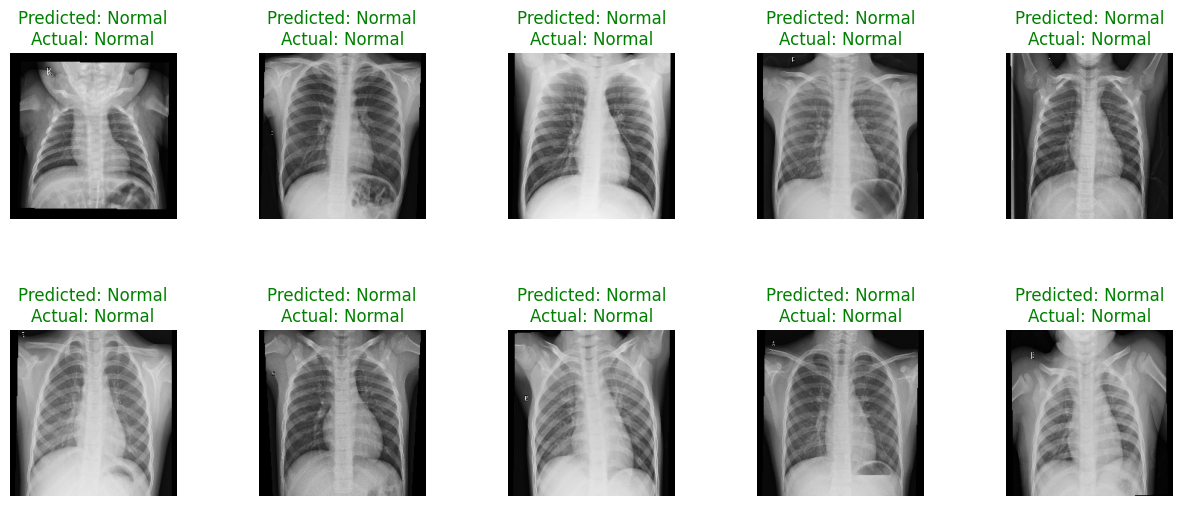

In [ ]:
input_images = np.array(test_images[:10])
true_labels = np.array(true_labels[:10])
pred_labels = np.array(pred_labels[:10])

class_names = ['Normal', 'Pneumonia']

display_random_test_images(input_images, true_labels, pred_labels, class_names, num_images=10)


Confusion Matrix:
[[197  37]
 [ 90 300]]


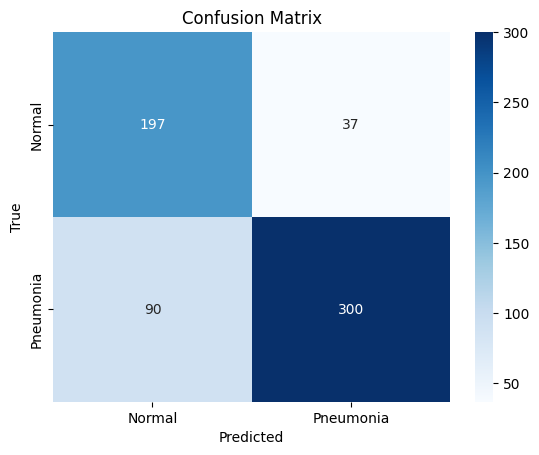

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

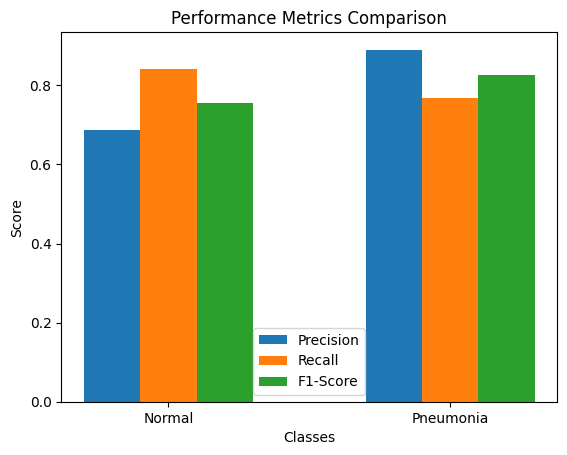

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

labels = ['Normal', 'Pneumonia']

x = range(len(labels))
width = 0.2

plt.bar([i - width for i in x], precision, width=width, label='Precision')
plt.bar(x, recall, width=width, label='Recall')
plt.bar([i + width for i in x], f1_score, width=width, label='F1-Score')

plt.xticks(x, labels)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.show()

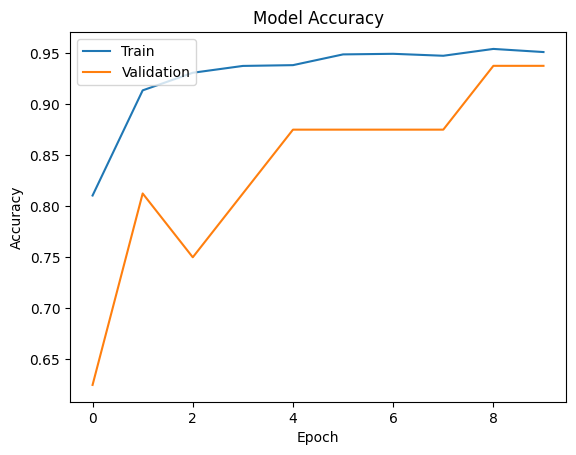

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

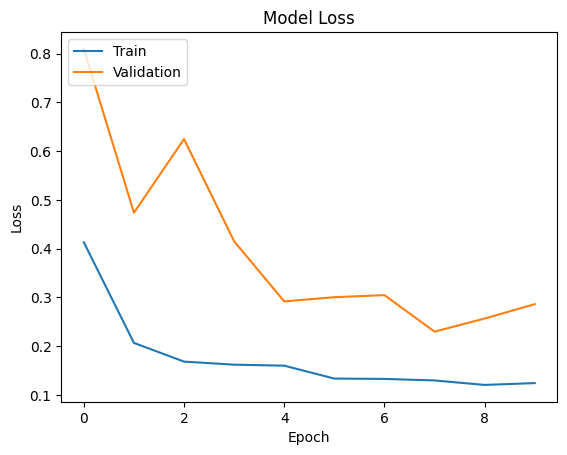

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()